# Financial Literacy and Saving Behavior

1. Primary Question: How does financial literacy mediate the relationship between age and saving
behavior?
2. Estimand: The indirect effect of age on saving behavior through financial literacy and the direct
effect of age on saving behavior.

### Data Description

The Student Spending Dataset dataset contains information about students' demographics, financial
literacy, income, expenses, and saving behaviors. Key variables include:

*   Age: Numerical, representing student age.
*   Financial Literacy: Binary (0 or 1), indicating whether a student exhibits financially literate
behavior.
*   Saving Behavior: Continuous, representing the difference between total income and expenses.
*   Other Variables: Monthly income, financial aid, tuition, housing, food, entertainment, and
others.

The dataset comprises 1,000 records with no missing values, ensuring a clean data source for analysis.
It was obtained from Kaggle.


In [21]:
# Data Description
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import networkx as nx

def standardize(series):
    return (series - series.mean()) / series.std()

az.rcParams["stats.hdi_prob"] = 0.89

data = pd.read_csv("student_spending.csv")

print("Dataset Information:")
print(data.info())

print("\nDescriptive Statistics:")
print(data.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                1000 non-null   int64 
 1   age                       1000 non-null   int64 
 2   gender                    1000 non-null   object
 3   year_in_school            1000 non-null   object
 4   major                     1000 non-null   object
 5   monthly_income            1000 non-null   int64 
 6   financial_aid             1000 non-null   int64 
 7   tuition                   1000 non-null   int64 
 8   housing                   1000 non-null   int64 
 9   food                      1000 non-null   int64 
 10  transportation            1000 non-null   int64 
 11  books_supplies            1000 non-null   int64 
 12  entertainment             1000 non-null   int64 
 13  personal_care             1000 non-null   int64 
 14  tech

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:345: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


### Data Preprocessing

In [22]:
data.drop(columns=['Unnamed: 0'], inplace=True)

income_columns = ['monthly_income', 'financial_aid']
data['total_income'] = data[income_columns].sum(axis=1)

expense_columns = ['food', 'housing', 'transportation', 'books_supplies',
                   'entertainment', 'personal_care', 'technology',
                   'health_wellness', 'miscellaneous']
data['total_expenses'] = data[expense_columns].sum(axis=1)

data['saving_behavior'] = data['total_income'] - data['total_expenses']

data['financial_literacy'] = data['saving_behavior'].apply(lambda x: 1 if x > 0 else 0)

print(data.head(10))

   age      gender year_in_school             major  monthly_income  \
0   19  Non-binary       Freshman        Psychology             958   
1   24      Female         Junior         Economics            1006   
2   24  Non-binary         Junior         Economics             734   
3   23      Female         Senior  Computer Science             617   
4   20      Female         Senior  Computer Science             810   
5   25  Non-binary      Sophomore  Computer Science             523   
6   23      Female       Freshman       Engineering            1354   
7   23      Female         Junior         Economics             631   
8   22  Non-binary         Senior  Computer Science            1402   
9   18      Female         Junior  Computer Science            1423   

   financial_aid  tuition  housing  food  transportation  ...  entertainment  \
0            270     5939      709   296             123  ...             41   
1            875     4908      557   365              85  

### Causal Model

1. Age influences financial literacy (Age→Financial Literacy).
2. Financial literacy influences saving behavior (Financial Literacy→Saving Behavior).
3. Age may also directly impact saving behavior (Age→Saving Behavior).

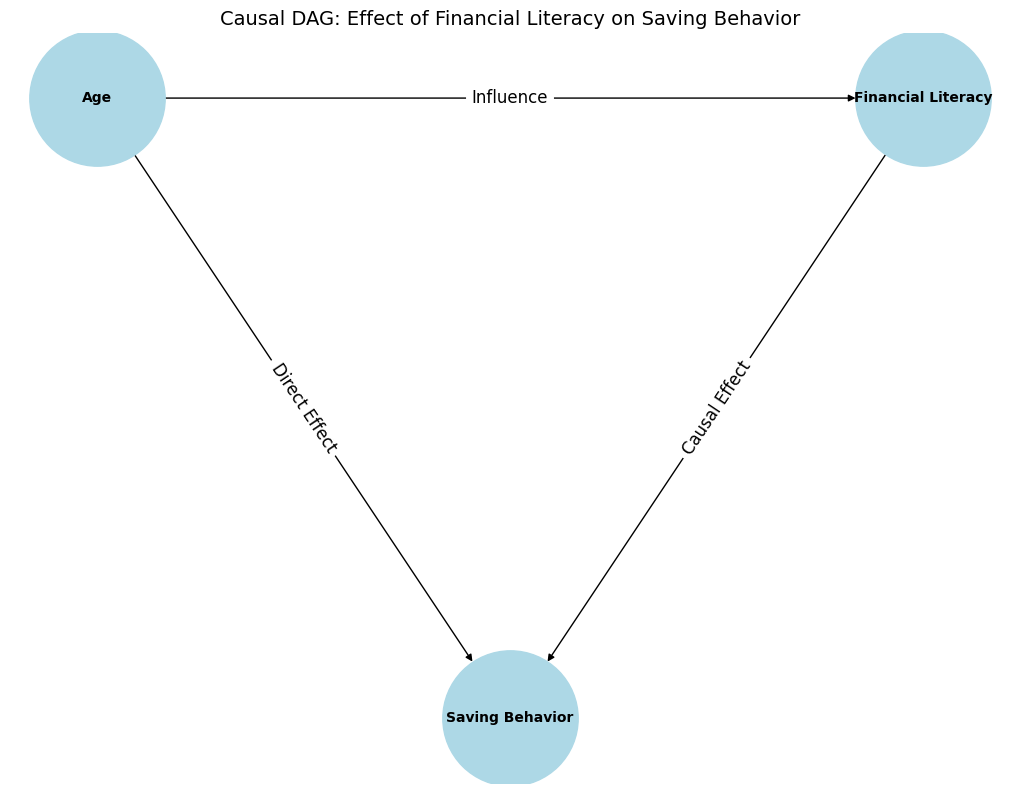

In [23]:
G = nx.DiGraph()

nodes = ['Age', 'Financial Literacy', 'Saving Behavior']
G.add_nodes_from(nodes)

edges = [
    ('Age', 'Financial Literacy'),
    ('Age', 'Saving Behavior'),
    ('Financial Literacy', 'Saving Behavior')
]
G.add_edges_from(edges)

plt.figure(figsize=(10, 7.5))

pos = {
        'Age': (0, 1),
        'Financial Literacy': (1, 1),
        'Saving Behavior': (0.5, 0.5)
    }

nx.draw(G, pos,
        with_labels=True,
        node_color='lightblue',
        node_size=9500,
        font_size=10,
        font_weight='bold',
        arrows=True,
        edge_color='black')

edge_labels = {
        ('Age', 'Financial Literacy'): 'Influence',
        ('Age', 'Saving Behavior'): 'Direct Effect',
        ('Financial Literacy', 'Saving Behavior'): 'Causal Effect'
    }
nx.draw_networkx_edge_labels(G,pos, edge_labels=edge_labels, font_size=12)

plt.title('Causal DAG: Effect of Financial Literacy on Saving Behavior', fontsize=14)

plt.axis('off')
plt.show()

Hypothesis
* Age is a plausible exogenous variable affecting financial literacy.
* Financial literacy mediates the relationship between age and saving behavior.
* Other potential confounders, such as education level, are assumed constant or negligible.

### Statistical Model

Output()

Output()

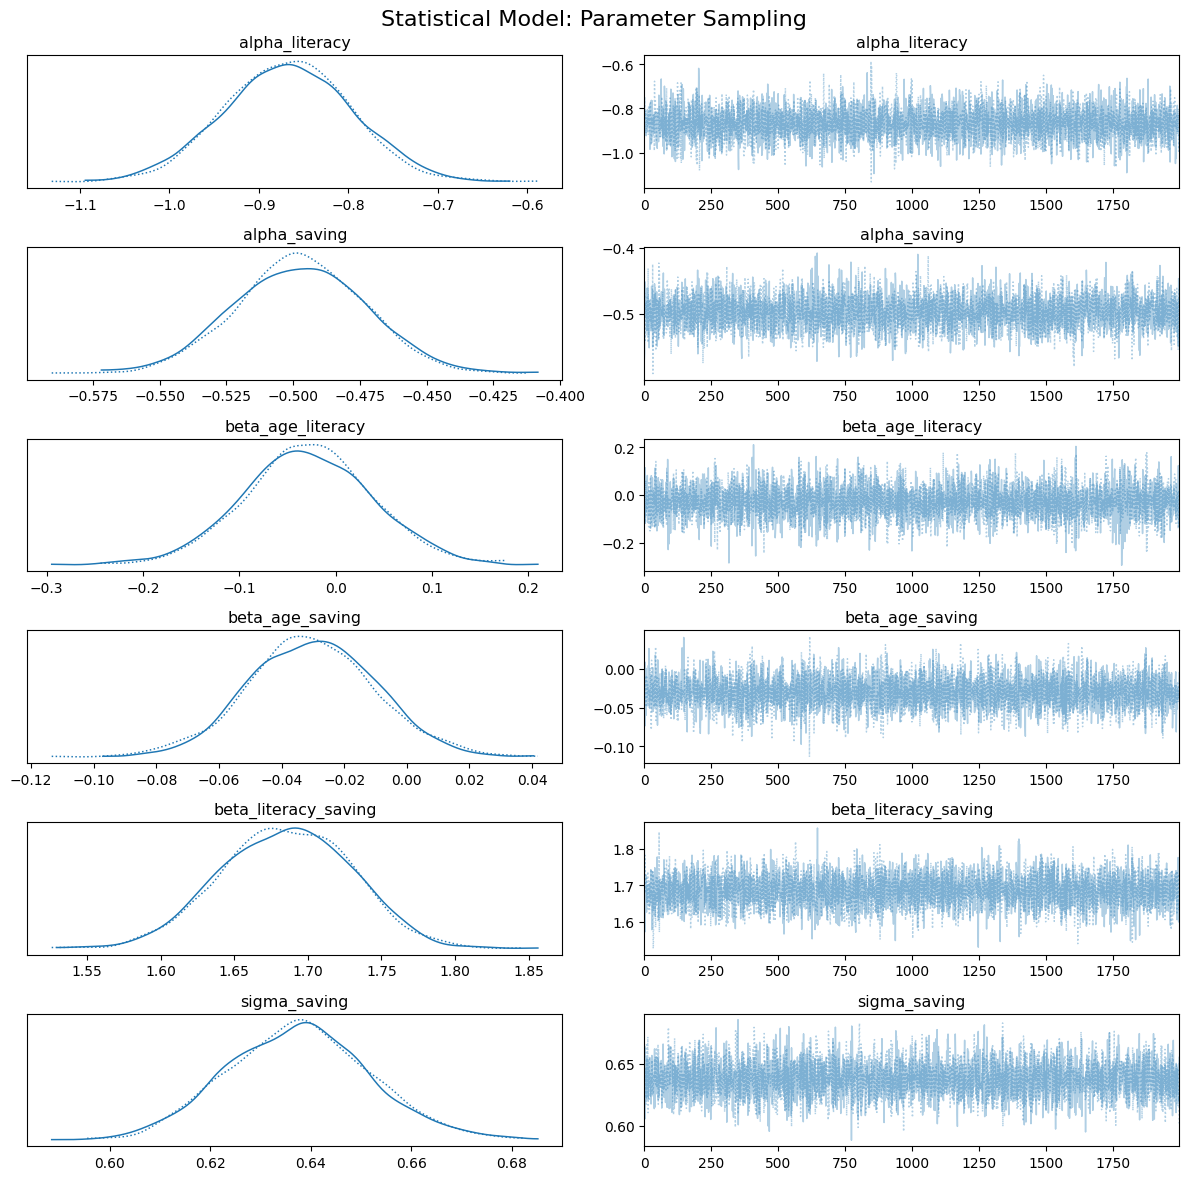

In [24]:
# Statistical Model Definition
with pm.Model() as statistical_model:
    # Priors for financial literacy
    alpha_literacy = pm.Normal("alpha_literacy", mu=0, sigma=1)
    beta_age_literacy = pm.Normal("beta_age_literacy", mu=0, sigma=1)

    # Financial literacy linear model
    literacy = alpha_literacy + beta_age_literacy * standardize(data['age'])
    financial_literacy = pm.Bernoulli("financial_literacy", logit_p=literacy, observed=data['financial_literacy'])

    # Priors for saving behavior
    alpha_saving = pm.Normal("alpha_saving", mu=0, sigma=1)
    beta_literacy_saving = pm.Normal("beta_literacy_saving", mu=0, sigma=1)
    beta_age_saving = pm.Normal("beta_age_saving", mu=0, sigma=1)
    sigma_saving = pm.HalfNormal("sigma_saving", sigma=1)

    # Saving behavior linear model
    mu_saving = (
        alpha_saving
        + beta_literacy_saving * data['financial_literacy']
        + beta_age_saving * standardize(data['age'])
    )
    saving_behavior_obs = pm.Normal(
        "saving_behavior_obs", mu=mu_saving, sigma=sigma_saving, observed=standardize(data['saving_behavior'])
    )

    # Sampling from the posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Visualize Statistical Model Parameters
az.plot_trace(trace)
plt.suptitle("Statistical Model: Parameter Sampling", fontsize=16)
plt.tight_layout()
plt.show()


We employed a Bayesian mediation approach with the following models:
1. Financial Literacy Model:
P(Financial Literacy=1∣Age)=logit−1(αliteracy+βage_literacy⋅Age)
2. Saving Behavior Model:
Saving Behavior=αsaving+βliteracy_saving⋅Financial Literacy+βage_saving⋅Age+ϵ

Priors and Justification
* Regression Coefficients: Weakly informative priors (e.g., normal distributions) prevent
overfitting and reflect plausible effect sizes.
* Variance Components: Hyperparameters follow half-Cauchy distributions to capture
uncertainty effectively.

Posterior Model

                       mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
alpha_literacy       -0.868  0.071    -0.982     -0.757      0.001    0.001   
beta_age_literacy    -0.029  0.068    -0.132      0.082      0.001    0.001   
alpha_saving         -0.497  0.024    -0.537     -0.459      0.000    0.000   
beta_literacy_saving  1.685  0.044     1.615      1.753      0.001    0.000   
beta_age_saving      -0.030  0.020    -0.062      0.002      0.000    0.000   

                      ess_bulk  ess_tail  r_hat  
alpha_literacy          5495.0    2889.0    1.0  
beta_age_literacy       6322.0    2800.0    1.0  
alpha_saving            4669.0    3015.0    1.0  
beta_literacy_saving    4428.0    2801.0    1.0  
beta_age_saving         6178.0    3051.0    1.0  


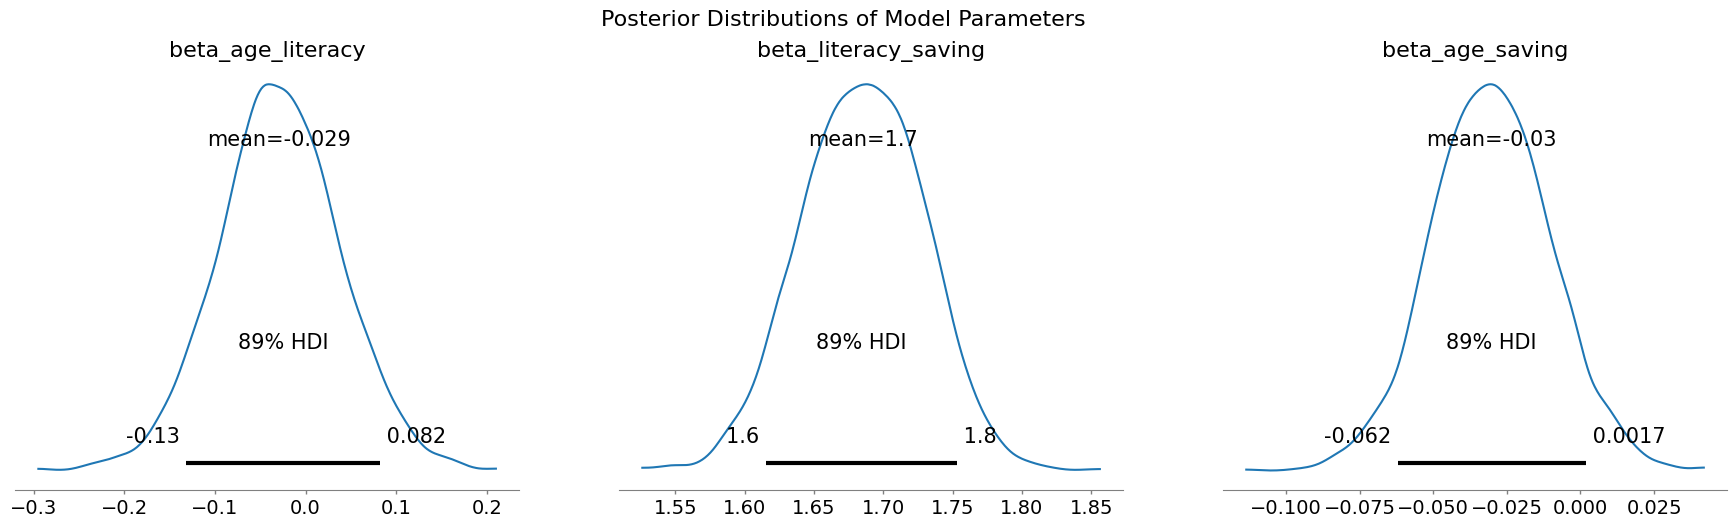

In [25]:
# Posterior Model
summary = az.summary(trace, var_names=[
    'alpha_literacy',
    'beta_age_literacy',
    'alpha_saving',
    'beta_literacy_saving',
    'beta_age_saving'
])
print(summary)

# Visualize posterior distributions
az.plot_posterior(trace, var_names=[
    'beta_age_literacy',
    'beta_literacy_saving',
    'beta_age_saving'
])
plt.suptitle("Posterior Distributions of Model Parameters", fontsize=16)
plt.show()

Posterior Model Diagnostics
* Convergence: Trace plots for parameters confirm well-mixed posterior samples, indicating
proper convergence. Effective sample sizes are adequate for reliable inference.
* Posterior Predictive Checks: Model predictions align closely with observed data, as visualized
in histograms of posterior samples versus observed values.

Posterior Predictive Checks

Output()

Output()

                       mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
alpha_literacy       -0.375  0.512    -1.206      0.420      0.015    0.012   
alpha_saving          0.690  0.291     0.239      1.162      0.008    0.006   
beta_age_literacy     0.022  0.022    -0.014      0.056      0.001    0.001   
beta_age_saving      -0.084  0.012    -0.105     -0.067      0.000    0.000   
beta_literacy_saving  2.483  0.093     2.333      2.627      0.002    0.002   
...                     ...    ...       ...        ...        ...      ...   
p_literacy[496]       0.546  0.028     0.504      0.592      0.001    0.000   
p_literacy[497]       0.561  0.039     0.496      0.621      0.001    0.001   
p_literacy[498]       0.524  0.024     0.487      0.562      0.001    0.000   
p_literacy[499]       0.503  0.036     0.448      0.563      0.001    0.001   
sigma                 1.033  0.034     0.977      1.084      0.001    0.001   

                      ess_bulk  ess_tail  r_hat  
a

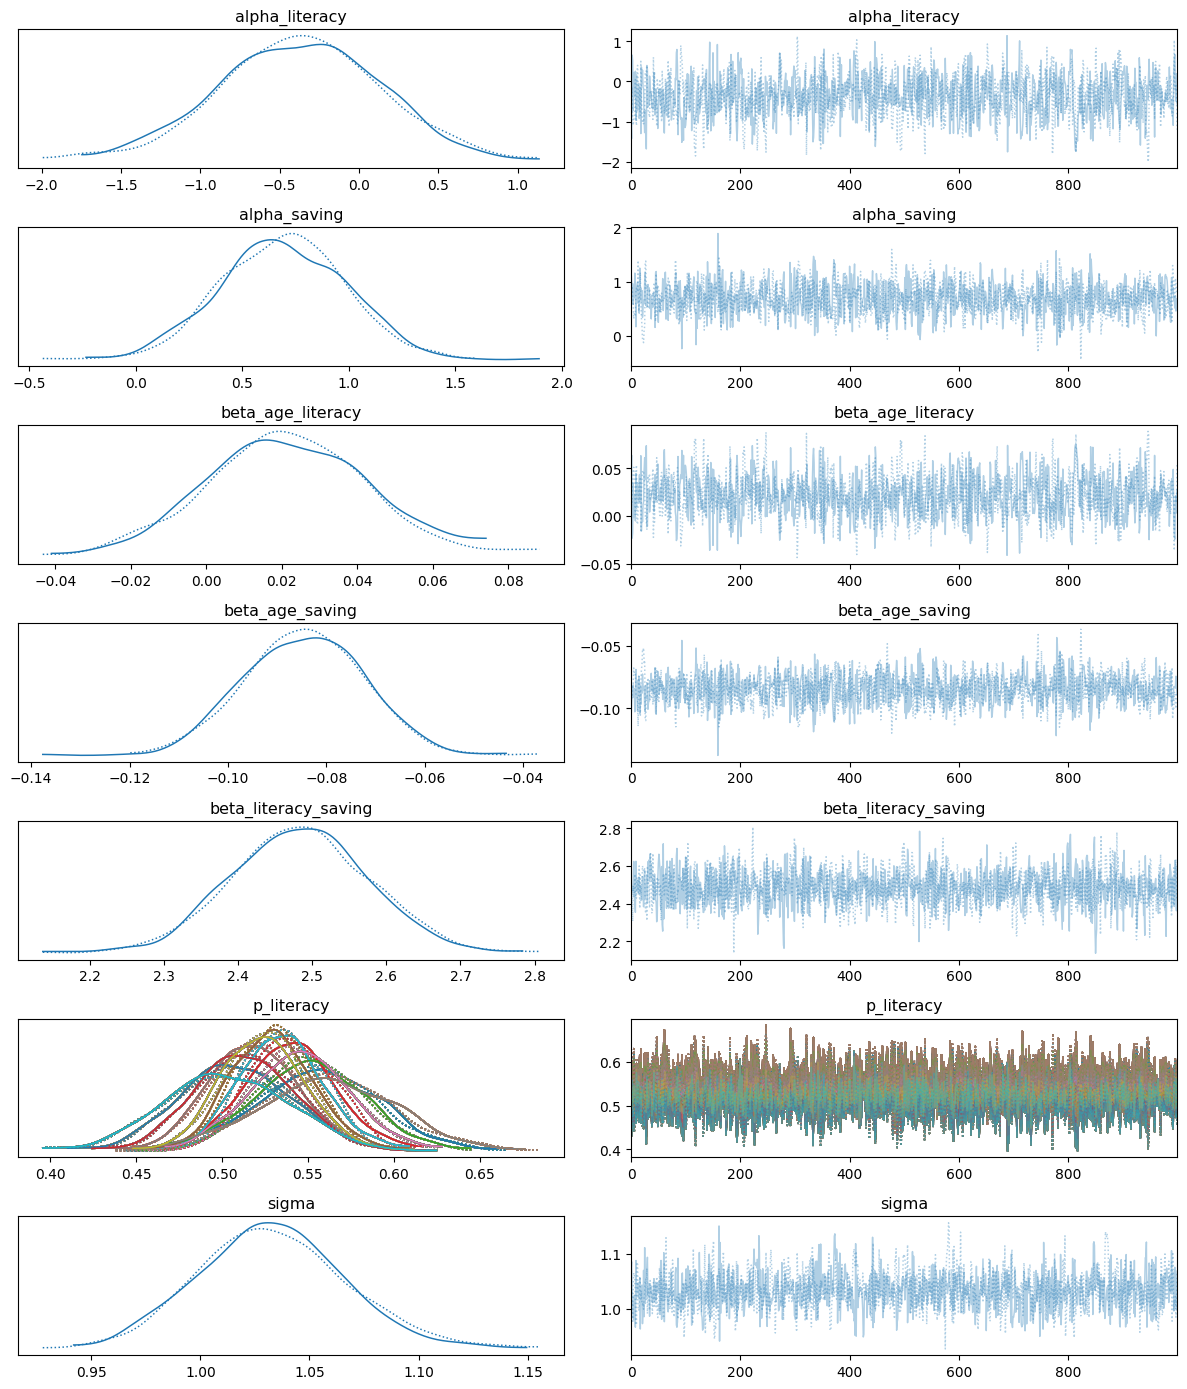

In [26]:
np.random.seed(42)
n_samples = 500
age = np.random.randint(18, 30, size=n_samples)
true_alpha_literacy = -0.5
true_beta_age_literacy = 0.03
true_alpha_saving = 1.0
true_beta_literacy_saving = 2.5
true_beta_age_saving = -0.1
true_sigma = 1.0

# Generate financial literacy probabilities and observations
logit_p_simulated = true_alpha_literacy + true_beta_age_literacy * age
p_simulated = 1 / (1 + np.exp(-logit_p_simulated))
financial_literacy_simulated = np.random.binomial(1, p_simulated, size=n_samples)

# Generate saving behavior
saving_behavior_simulated = (
    true_alpha_saving
    + true_beta_literacy_saving * financial_literacy_simulated
    + true_beta_age_saving * age
    + np.random.normal(0, true_sigma, size=n_samples)
)

# Fit model to simulated data
simulated_data = pd.DataFrame({
    "age": age,
    "financial_literacy": financial_literacy_simulated,
    "saving_behavior": saving_behavior_simulated,
})

with pm.Model() as simulated_model:
    alpha_literacy = pm.Normal("alpha_literacy", mu=0, sigma=1)
    beta_age_literacy = pm.Normal("beta_age_literacy", mu=0, sigma=1)
    alpha_saving = pm.Normal("alpha_saving", mu=0, sigma=1)
    beta_literacy_saving = pm.Normal("beta_literacy_saving", mu=0, sigma=1)
    beta_age_saving = pm.Normal("beta_age_saving", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    logit_p = alpha_literacy + beta_age_literacy * simulated_data['age']
    p_literacy = pm.Deterministic("p_literacy", pm.math.sigmoid(logit_p))
    financial_literacy_obs = pm.Bernoulli("financial_literacy_obs", p=p_literacy, observed=simulated_data['financial_literacy'])

    expected_saving = (
        alpha_saving
        + beta_literacy_saving * simulated_data['financial_literacy']
        + beta_age_saving * simulated_data['age']
    )
    saving_behavior_obs = pm.Normal(
        "saving_behavior_obs",
        mu=expected_saving,
        sigma=sigma,
        observed=simulated_data['saving_behavior']
    )
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

# Summarize results
summary_simulated = az.summary(trace, hdi_prob=0.89)
print(summary_simulated)

# Plot parameter estimates
az.plot_trace(trace)
plt.tight_layout()
plt.show()

### Findings
1. Direct Effect of Age: Older students show slightly lower saving behavior, though the effect is marginal.
2. Indirect Effect via Financial Literacy: Financial literacy significantly improves saving behavior,
supporting its role as a mediator.

These results highlight financial literacy as the stronger determinant of saving behavior compared to
age.


### Insights Gained
* Financial Literacy: A critical driver of saving behavior, independent of age.
* Age: Exhibits a small negative direct effect on saving behavior and financial literacy.

### Contradictions and Possible Reasons
While older individuals were hypothesized to save more due to increased financial stability, the data
reveals a slight decline in saving behavior with age. This contradiction can be attributed to several
factors:
* Family Support: Older individuals may have higher financial responsibilities, such as
supporting family members or dependents.
* Educational Expenses: Paying for children's education could significantly reduce disposable
income.
* Debt Obligations: Commitments such as mortgage payments or other long-term EMIs may
restrict saving capacity.
These findings highlight the complexity of saving behavior, which is influenced not only by financial
literacy but also by life-stage-specific financial burdens.

### Future Work

Addressing Confounders in Future Work
To address these confounders, future work could:
1. Include Additional Variables: Collect and include data on education level, field of study, and
socioeconomic status as control variables in the model.
2. Stratified Analysis: Perform subgroup analyses based on these confounders to understand their
specific impacts.
3. Instrumental Variables: Identify instruments that influence financial literacy but are unrelated
to saving behavior to isolate causal effects.
4. Propensity Score Matching: Use matching techniques to compare individuals with similar
confounder profiles.
5. Sensitivity Analysis: Assess the robustness of the findings to unmeasured confounders by
estimating their potential influence.

Incorporating these steps would provide a more robust understanding of the relationships and ensure
that the conclusions drawn are less biased by unaccounted-for factors.